In [1]:
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# 数据初探

In [3]:
train.describe()

,User ID,Age,MonthlySalary,Happiness
count,2.990000e+02,299.000000,299.000000,299.000000
mean,8.139380e+06,35.096990,69331.103679,0.267559
std,4.750734e+04,10.164451,34577.906432,0.443428
min,8.055621e+06,18.000000,15000.000000,0.000000
25%,8.097842e+06,27.000000,43000.000000,0.000000
50%,8.140797e+06,35.000000,70000.000000,0.000000
75%,8.177996e+06,41.000000,87500.000000,1.000000
max,8.221319e+06,60.000000,150000.000000,1.000000


In [4]:
#查看是否有空值
train.isnull().sum()

User ID          0
Age              0
MonthlySalary    0
Happiness        0
dtype: int64

In [5]:
test.isnull().sum()

User ID          0
Age              0
MonthlySalary    0
Happiness        0
dtype: int64

In [6]:
#去除重复值
train = train.drop_duplicates()
test = test.drop_duplicates()

In [7]:
train.shape

(299, 4)

In [8]:
test.shape

(101, 4)

In [9]:
train.head()

,User ID,Age,MonthlySalary,Happiness
0,8.094168e+06,19,19000,0
1,8.218457e+06,35,20000,0
2,8.123545e+06,26,43000,0
3,8.079992e+06,27,57000,0
4,8.213829e+06,19,76000,0


In [10]:
test.head()

,User ID,Age,MonthlySalary,Happiness
0,79470,46,117000,1
1,79363,58,38000,1
2,78782,48,74000,1
3,79207,37,137000,1
4,78375,37,79000,1


# 建模预测

In [11]:
#删除不需要的列
del_feature = ['User ID','Happiness']
features = [i for i in train.columns if i not in del_feature]

In [12]:
train_x = train[features]
train_y = train['Happiness'].values
test_x = test[features]
test_y = test['Happiness'].values

# 训练参数的选取

In [13]:
params = {'num_leaves': 60,
          'min_data_in_leaf': 30,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "min_sum_hessian_in_leaf": 6,
          "boosting": "gbdt",
          "feature_fraction": 0.9,
          "bagging_freq": 1,
          "bagging_fraction": 0.8,
          "bagging_seed": 11,
          "lambda_l1": 0.1,
          # 'lambda_l2': 0.001,
          "verbosity": -1,
          "nthread": -1,
          'metric': {'binary_logloss', 'auc'},
          "random_state": 2019,
          # 'device': 'gpu'
          }

# 五折交叉

In [14]:
folds = KFold(n_splits=5, shuffle=True, random_state=2048)
prob_oof = np.zeros((train_x.shape[0], ))
test_pred_prob = np.zeros((test_x.shape[0],))

In [15]:
num_round = 1000
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train)):
    print("fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train_x.iloc[trn_idx], label=train_y[trn_idx])
    val_data = lgb.Dataset(train_x.iloc[val_idx], label=train_y[val_idx])
    
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds=60)
    prob_oof[val_idx] = clf.predict(train_x.iloc[val_idx], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    test_pred_prob += clf.predict(test_x[features], num_iteration=clf.best_iteration) / folds.n_splits

fold 1
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[14]	training's auc: 0.975192	training's binary_logloss: 0.505794	valid_1's auc: 0.91744	valid_1's binary_logloss: 0.446502
fold 2
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[69]	training's auc: 0.966761	training's binary_logloss: 0.336835	valid_1's auc: 0.953993	valid_1's binary_logloss: 0.324376
fold 3
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[2]	training's auc: 0.954423	training's binary_logloss: 0.54902	valid_1's auc: 0.983125	valid_1's binary_logloss: 0.635819
fold 4
Training until validation scores don't improve for 60 rounds.
Early stopping, best iteration is:
[5]	training's auc: 0.952339	training's binary_logloss: 0.532473	valid_1's auc: 0.977535	valid_1's binary_logloss: 0.592489
fold 5
Training until validation scores don't improve for 60 rounds.
Early stopping, bes

# roc评估

In [16]:
sub = test[['User ID']]

In [17]:
#train
roc_auc_score(train_y,prob_oof)

0.9093607305936073

In [18]:
sub['Happiness'] = test_pred_prob

In [19]:
sub.loc[sub.Happiness<=0.28,'Happiness'] = 0
sub.loc[sub.Happiness>0.28,'Happiness'] = 1

In [20]:
predicton=np.array(sub.Happiness)

In [21]:
predicton

array([1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.])

In [22]:
#test
score = roc_auc_score(predicton,test_y)
score

0.906883445945946

In [23]:
sub.to_csv('./data/'+str('%.6f'%score)+'.csv',encoding='utf-8',index=False)

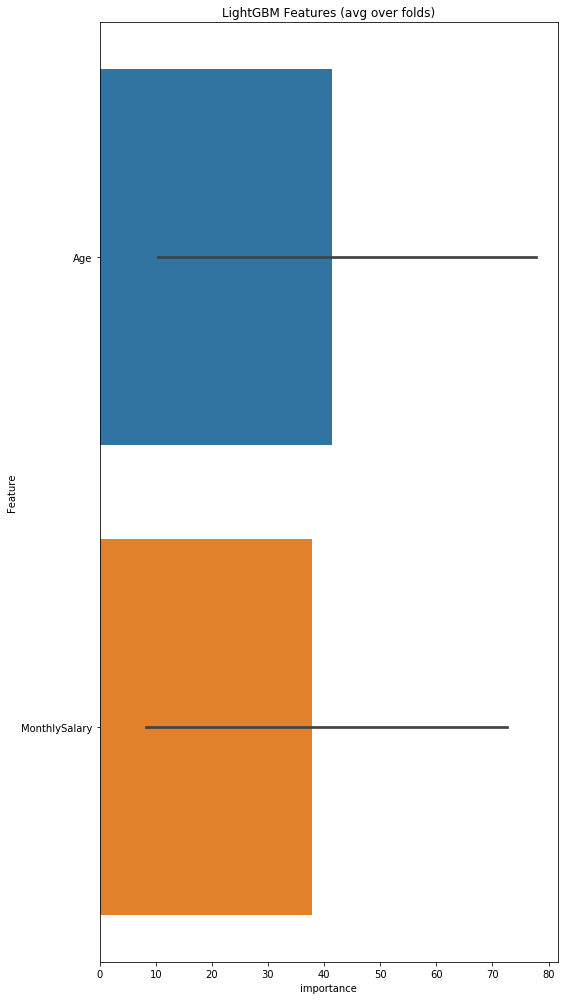

In [24]:
## plot feature importance
cols = (feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)].sort_values(by='importance',ascending=False)
plt.figure(figsize=(8, 14))
sns.barplot(y="Feature",
            x="importance",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()